In [1]:
import os
import numpy as np

# VE is the last column
# Folder containing your files
folder_path = '/Users/federicacardillo/Downloads/results-3'  # <-- change this

# List to store all data
all_data = []

# Loop over all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        data = np.loadtxt(file_path)
        all_data.append(data)

# Stack all data vertically (rows from all files)
all_data = np.vstack(all_data)

# Compute summary stats for each column
for i in range(all_data.shape[1]):
    col = all_data[:, i]
    print(f"Column {i+1}:")
    print(f" Median = {np.median(col):.5f}")
    print(f" Min = {np.min(col):.5f}")
    print(f" Max = {np.max(col):.5f}")
    print('-'*40)

Column 1:
 Median = 0.72599
 Min = 0.05000
 Max = 9.99277
----------------------------------------
Column 2:
 Median = 0.87399
 Min = 0.00000
 Max = 2.90610
----------------------------------------
Column 3:
 Median = 833.00000
 Min = 0.00000
 Max = 2450.00000
----------------------------------------
Column 4:
 Median = 0.43261
 Min = 0.00005
 Max = 3.39744
----------------------------------------


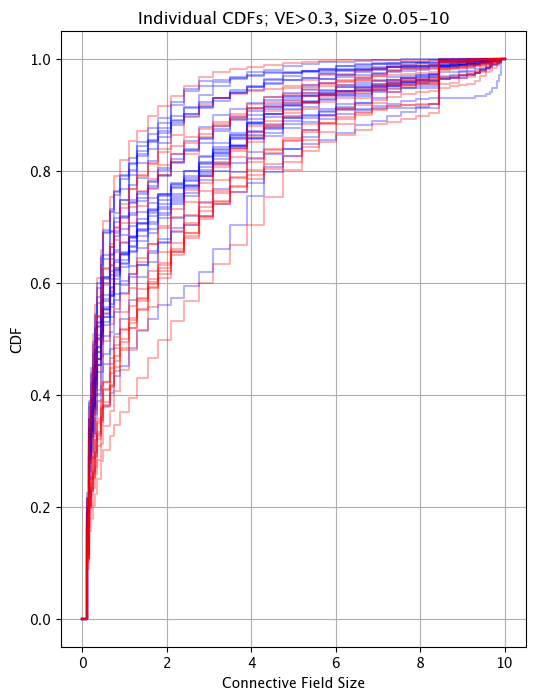

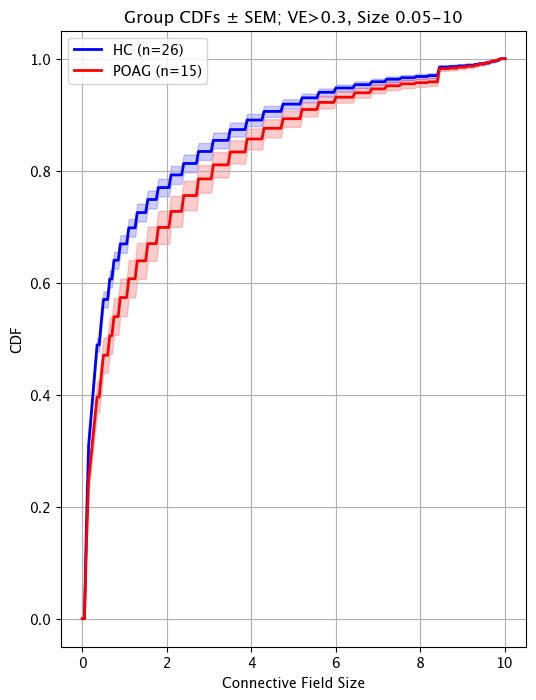

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- Settings ---
folder_path = '/Users/federicacardillo/Downloads/results'
# --- Exclude subjects ---
#exclude_subjects = ["sub-02_bestfit.txt"]   # put here any filenames you want to skip
#exclude_subjects = []
# Healthy controls (HC) = sub-20 to sub-46
hc_subjects = [f"sub-{i:02d}_bestfit.txt" for i in range(20, 47)]

# Column indices
ve_col = 3  # Variance explained
size_col = 0 # Connective Field size

# Filters
size_min, size_max = 0.05, 10

# --- Load data ---
hc_data_list, poag_data_list = [], []
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):

        # skip if in exclusion list
        if filename in exclude_subjects:
            continue

        file_path = os.path.join(folder_path, filename)
        data = np.loadtxt(file_path)

        # Apply VE and Size filters
        ve_mask = data[:, ve_col] > 0.3
        size_mask = (data[:, size_col] >= size_min) & (data[:, size_col] <= size_max)
        keep_mask = ve_mask & size_mask
        data = data[keep_mask]

        if data.size == 0:
            continue

        if filename in hc_subjects:
            hc_data_list.append(data)
        else:
            poag_data_list.append(data)


def hist_cdf(data, bins=200):
    counts, bin_edges = np.histogram(
        data, bins=bins, range=(0, size_max), density=True
    )
    cdf_vals = np.cumsum(counts * np.diff(bin_edges))  # integrate pdf
    cdf_vals /= cdf_vals[-1]  # normalize to [0,1]

    # prepend (0,0) so the step starts at zero properly
    cdf_x = np.concatenate(([0], bin_edges[1:]))
    cdf_y = np.concatenate(([0], cdf_vals))

    return cdf_x, cdf_y

col_idx = size_col

# --- FIGURE 1: subject-level CDFs ---
plt.figure(figsize=(6, 8))
for subj in hc_data_list:
    bins, cdf = hist_cdf(subj[:, col_idx])
    plt.step(bins, cdf, where="post", color="blue", alpha=0.3)
for subj in poag_data_list:
    bins, cdf = hist_cdf(subj[:, col_idx])
    plt.step(bins, cdf, where="post", color="red", alpha=0.3)

plt.xlabel("Connective Field Size")
plt.ylabel("CDF")
plt.title(f"Individual CDFs; VE>0.3, Size {size_min}-{size_max}")
plt.grid(True)
plt.show()

# --- FIGURE 2: group mean ± SEM ---
plt.figure(figsize=(6, 8))

# Healthy controls
if hc_data_list:
    hc_cdfs = [hist_cdf(subj[:, col_idx])[1] for subj in hc_data_list]
    bins = hist_cdf(hc_data_list[0][:, col_idx])[0]
    hc_cdfs = np.array(hc_cdfs)
    mean_hc = np.nanmean(hc_cdfs, axis=0)
    sem_hc = np.nanstd(hc_cdfs, axis=0, ddof=1) / np.sqrt(hc_cdfs.shape[0])
    plt.plot(bins, mean_hc, color="blue", linewidth=2, label=f"HC (n={len(hc_data_list)})")
    plt.fill_between(bins, mean_hc - sem_hc, mean_hc + sem_hc, color="blue", alpha=0.2)

# POAG patients
if poag_data_list:
    poag_cdfs = [hist_cdf(subj[:, col_idx])[1] for subj in poag_data_list]
    bins = hist_cdf(poag_data_list[0][:, col_idx])[0]
    poag_cdfs = np.array(poag_cdfs)
    mean_poag = np.nanmean(poag_cdfs, axis=0)
    sem_poag = np.nanstd(poag_cdfs, axis=0, ddof=1) / np.sqrt(poag_cdfs.shape[0])
    plt.plot(bins, mean_poag, color="red", linewidth=2, label=f"POAG (n={len(poag_data_list)})")
    plt.fill_between(bins, mean_poag - sem_poag, mean_poag + sem_poag, color="red", alpha=0.2)

plt.xlabel("Connective Field Size")
plt.ylabel("CDF")
plt.title(f"Group CDFs ± SEM; VE>0.3, Size {size_min}-{size_max}")
plt.legend()
plt.grid(True)
plt.show()




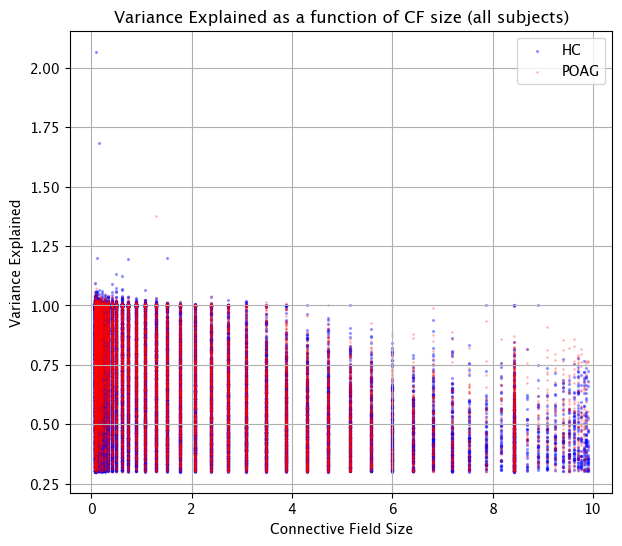

In [7]:
# --- FIGURE 3: Variance Explained vs Connective Field Size ---
plt.figure(figsize=(7, 6))

# Plot all HC points in blue
for subj in hc_data_list:
    plt.scatter(subj[:, size_col], subj[:, ve_col],
                color="blue", alpha=0.3, s=2, label="HC" if 'HC' not in plt.gca().get_legend_handles_labels()[1] else "")

# Plot all POAG points in red
for subj in poag_data_list:
    plt.scatter(subj[:, size_col], subj[:, ve_col],
                color="red", alpha=0.2, s=1, label="POAG" if 'POAG' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel("Connective Field Size")
plt.ylabel("Variance Explained")
plt.title("Variance Explained as a function of CF size (all subjects)")
plt.legend()
plt.grid(True)
plt.show()

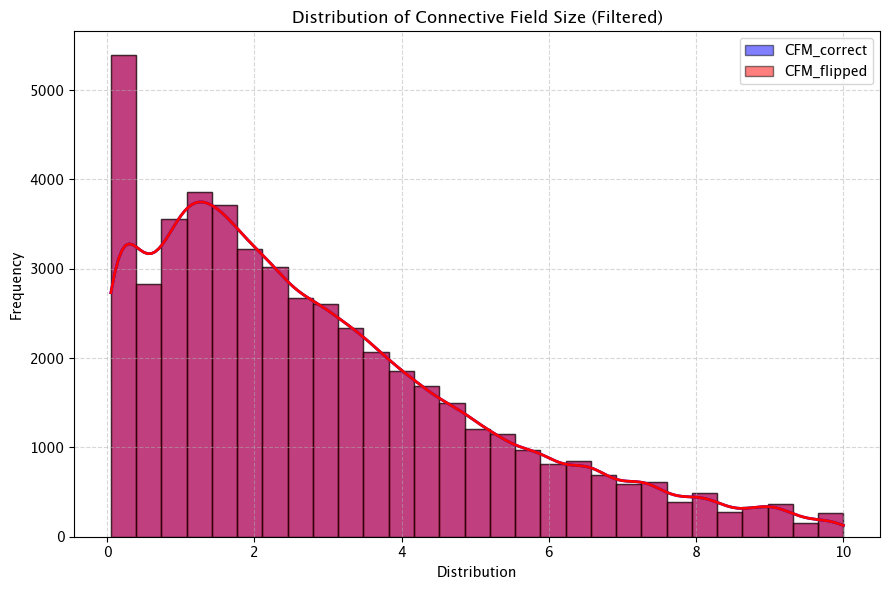

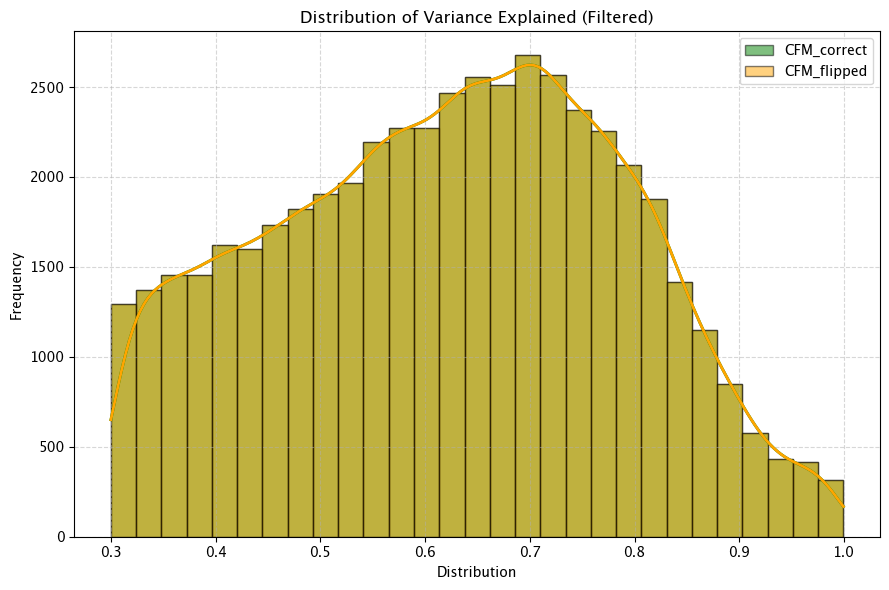

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from scipy.stats import gaussian_kde

# === PATHS ===
dir_large = "/Users/federicacardillo/Documents/EGRETAAA/UMCG/derivatives/CFM_correct/"
dir_small = "/Users/federicacardillo/Documents/EGRETAAA/UMCG/derivatives/CFM/"

# === PARAMETERS ===
hemis = ["lh", "rh"]
rois = ["V2-V1", "V3-V1"]
ecc_bound = (0.05, 7)        # eccentricity between 0.05 and 7
CFsize_bound = (0.05, 10)    # CF size between 0.05 and 10
r2_thr = 0.3                  # VE threshold

# === FUNCTION TO LOAD AND FILTER DATA ===
def load_best_fits_filtered(root_dir, ecc_bound, CFsize_bound, r2_thr):
    all_sigma = []
    all_ve = []
    all_subjects = []

    subject_dirs = sorted(glob(os.path.join(root_dir, "sub-*")))

    for sub_path in subject_dirs:
        subject = os.path.basename(sub_path)
        ses_dirs = glob(os.path.join(sub_path, "ses-*"))
        for ses_path in ses_dirs:
            for hemi in hemis:
                for roi in rois:
                    file_path = os.path.join(ses_path, "manual", "RET", "nordic", "GM", hemi, roi, "best_fits_prf.csv")
                    if os.path.exists(file_path):
                        df = pd.read_csv(file_path)
                        # Ensure numeric
                        for col in ["Best Sigma Finer", "Best Variance Explained Finer", "Source Eccentricity"]:
                            if col in df.columns:
                                df[col] = pd.to_numeric(df[col], errors="coerce")

                        # Apply filtering mask
                        mask = (
                            (df["Source Eccentricity"] >= ecc_bound[0]) &
                            (df["Source Eccentricity"] <= ecc_bound[1]) &
                            (df["Best Sigma Finer"] >= CFsize_bound[0]) &
                            (df["Best Sigma Finer"] <= CFsize_bound[1]) &
                            (df["Best Variance Explained Finer"] >= r2_thr)
                        )
                        df = df.loc[mask]

                        sigma = df["Best Sigma Finer"].dropna().values
                        ve = df["Best Variance Explained Finer"].dropna().values

                        all_sigma.extend(sigma)
                        all_ve.extend(ve)
                        all_subjects.extend([subject]*len(sigma))

    return np.array(all_sigma), np.array(all_ve), np.array(all_subjects)

# === LOAD FILTERED DATASETS ===
sigma_small, ve_small, subj_small = load_best_fits_filtered(dir_small, ecc_bound, CFsize_bound, r2_thr)
sigma_large, ve_large, subj_large = load_best_fits_filtered(dir_large, ecc_bound, CFsize_bound, r2_thr)

# === PLOT FUNCTION ===
def plot_distribution(data1, data2, label1, label2, title, color1, color2):
    plt.figure(figsize=(9,6))
    bins = np.linspace(min(data1.min(), data2.min()), max(data1.max(), data2.max()), 30)
    
    plt.hist(data1, bins=bins, alpha=0.5, label=label1, color=color1, edgecolor="black")
    plt.hist(data2, bins=bins, alpha=0.5, label=label2, color=color2, edgecolor="black")
    
    # KDE overlay
    x = np.linspace(bins.min(), bins.max(), 200)
    kde1, kde2 = gaussian_kde(data1), gaussian_kde(data2)
    plt.plot(x, kde1(x) * len(data1) * (bins[1]-bins[0]), color=color1, lw=2)
    plt.plot(x, kde2(x) * len(data2) * (bins[1]-bins[0]), color=color2, lw=2)
    
    # Median lines
    #plt.axvline(np.median(data1), color=color1, linestyle="--", label=f"Median {label1} = {np.median(data1):.2f}")
    #plt.axvline(np.median(data2), color=color2, linestyle="--", label=f"Median {label2} = {np.median(data2):.2f}")
    
    plt.xlabel("Distribution")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {title} (Filtered)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# === PLOT BEST SIGMA FINER AND VARIANCE EXPLAINED ===
plot_distribution(sigma_small, sigma_large, "CFM_correct", "CFM_flipped", "Connective Field Size", "blue", "red")
plot_distribution(ve_small, ve_large, "CFM_correct", "CFM_flipped", "Variance Explained", "green", "orange")

In [ ]:
# === FUNCTION TO LOAD DATA WITH HEMIS ===
from glob import glob
import os

subject_dirs = sorted(glob(os.path.join(dir_large, "sub-*")))
print(subject_dirs)
for sub_path in subject_dirs:
    ses_dirs = glob(os.path.join(sub_path, "ses-*"))
    print(f"{sub_path} sessions:", ses_dirs)
    for ses_path in ses_dirs:
        for hemi in ["lh", "rh"]:
            for roi in ["V2-V1", "V3-V1"]:
                file_path = os.path.join(ses_path, "manual", "RET", "nordic", "GM", hemi, roi, "best_fits_prf.csv")
                if os.path.exists(file_path):
                    print("Found file:", file_path)
                else:
                    print("Missing file:", file_path)
def load_data_per_hemi(root_dir, ecc_bound, CFsize_bound, r2_thr):
    data = [] 

[]
